In [254]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [255]:
# cwd = os.getcwd()
# cwd

In [256]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('TG.csv')
df=raw_csv_data.copy()

In [257]:
para = 'Recovered'

In [258]:
df.Date.describe()

count           115
unique          115
top       24-Jun-20
freq              1
Name: Date, dtype: object

In [259]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,1,0,0
1,15-Mar-20,2,1,0
2,16-Mar-20,1,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,8,0,0
...,...,...,...,...
110,02-Jul-20,1213,987,8
111,03-Jul-20,1892,1126,8
112,04-Jul-20,1850,1342,5
113,05-Jul-20,1590,1166,7


In [260]:
df.Date = pd.to_datetime(df.Date)

In [261]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0


In [262]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0
...,...,...,...,...
110,2020-07-02,1213,987,8
111,2020-07-03,1892,1126,8
112,2020-07-04,1850,1342,5
113,2020-07-05,1590,1166,7


In [263]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [264]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


In [265]:
# df.Date.describe()

In [266]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


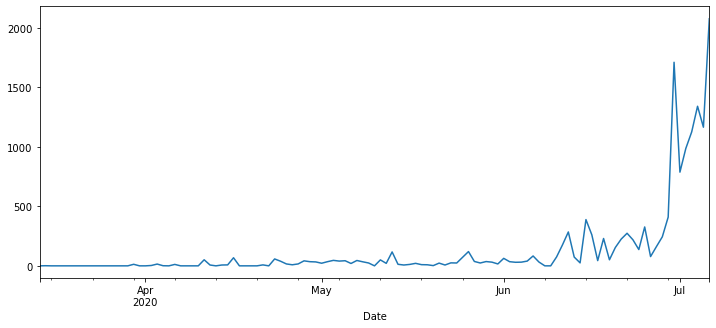

In [267]:
df[para].plot(figsize=(12,5));

In [268]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [269]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        3.644453
p-value                   1.000000
# lags used              13.000000
# observations          101.000000
critical value (1%)      -3.496818
critical value (5%)      -2.890611
critical value (10%)     -2.582277
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


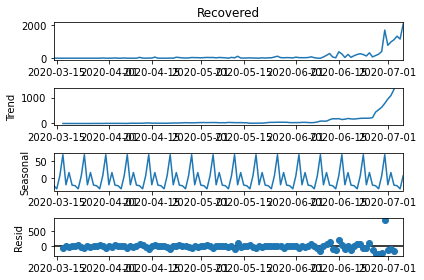

In [270]:
result = seasonal_decompose(df[para])
result.plot();

In [271]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [272]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.157942
p-value                  0.691421
# lags used             13.000000
# observations          99.000000
critical value (1%)     -3.498198
critical value (5%)     -2.891208
critical value (10%)    -2.582596
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [273]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=3)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1615.844, BIC=1621.299, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1557.828, BIC=1566.010, Time=0.027 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1513.880, BIC=1522.062, Time=0.129 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1613.924, BIC=1616.651, Time=0.011 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1529.896, BIC=1540.805, Time=0.025 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1512.460, BIC=1526.097, Time=0.112 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1512.614, BIC=1528.979, Time=0.139 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1487.965, BIC=1504.330, Time=0.215 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1488.087, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -735.182
Date:                Wed, 15 Jul 2020   AIC                           1478.364
Time:                        22:22:40   BIC                           1489.274
Sample:                             0   HQIC                          1482.791
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7480      4.017      0.435      0.663      -6.124       9.620
ma.L1         -1.6323      0.102    -15.977      0.000      -1.832      -1.432
ma.L2          0.7374      0.075      9.860      0.000       0.591       0.884
sigma2      2.542e+04   1597.007     15.915      0.000    2.23e+04    2.85e+04
===================================================================================
Ljung-Box (Q):                       18.67   Jarque-Bera (JB):             14930.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             141.03   Skew:                             6.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [274]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [275]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [276]:
# model = ARIMA(train[para],order=(0,2,2))
model = SARIMAX(train[para],order=(0,2,2),seasonal_order=(0,2,2,9))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Recovered   No. Observations:                  104
Model:             SARIMAX(0, 2, 2)x(0, 2, 2, 9)   Log Likelihood                -487.555
Date:                           Wed, 15 Jul 2020   AIC                            985.109
Time:                                   22:22:41   BIC                            997.263
Sample:                               03-14-2020   HQIC                           989.995
                                    - 06-25-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.8717      7.164     -0.261      0.794     -15.914      12.170
ma.L2          0.8719      6.228      0.140      0.889     -11.334      13.078
ma.S.L9       -1.6243      0.169     -9.595      0.000      -1.956      -1.293
ma.S.L18       0.7535      0.342      2.201      0.028       0.082       1.425
sigma2      3823.2223   2.74e+04      0.140      0.889   -4.98e+04    5.75e+04
===================================================================================
Ljung-Box (Q):                       30.50   Jarque-Bera (JB):               149.84
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              26.37   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [277]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2,2,1,3) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

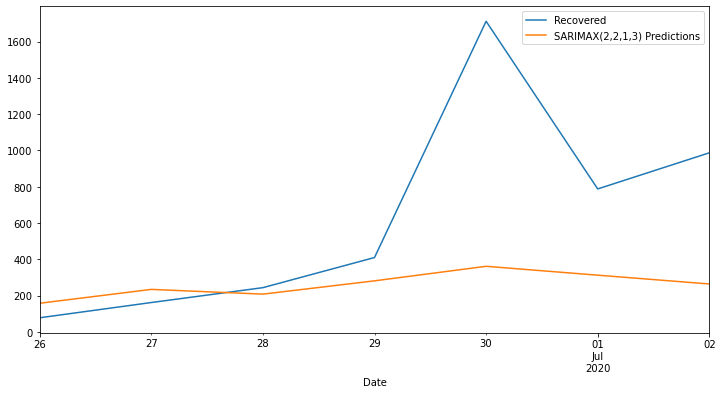

In [278]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [279]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [280]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

409.26923991088495

In [281]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

57.951947085551105 %


In [282]:
type(predictions)

pandas.core.series.Series

In [283]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,1,0,0,NaN,NaN
2020-03-15,2,1,0,NaN,NaN
2020-03-16,1,0,0,-2.0,NaN
2020-03-17,1,0,0,1.0,NaN
2020-03-18,8,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1213,987,8,1123.0,264.304024
2020-07-03,1892,1126,8,-60.0,NaN
2020-07-04,1850,1342,5,77.0,NaN


In [284]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Recovered': Date
 2020-06-26      78
 2020-06-27     162
 2020-06-28     244
 2020-06-29     410
 2020-06-30    1712
 2020-07-01     788
 2020-07-02     987
 Freq: D, Name: Recovered, dtype: int64,
 'Predicted_Recovered': 2020-06-26    158.040746
 2020-06-27    234.374984
 2020-06-28    208.308747
 2020-06-29    281.527020
 2020-06-30    361.647846
 2020-07-01    312.743413
 2020-07-02    264.304024
 Freq: D, Name: SARIMAX(2,2,1,3) Predictions, dtype: float64}

In [285]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Recovered,Predicted_Recovered
Date,,
2020-06-26,78,158.040746
2020-06-27,162,234.374984
2020-06-28,244,208.308747
2020-06-29,410,281.527020
2020-06-30,1712,361.647846
2020-07-01,788,312.743413
2020-07-02,987,264.304024


In [286]:
# predicted_csv = predicted_df.to_csv('Predicted_TG.csv')
predicted_csv = pd.read_csv('Predicted_TG.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_TG.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered
Date                                                                      
2020-06-26        985           922.294203         78           158.040746
2020-06-27       1087          1030.855362        162           234.374984
2020-06-28        983          1107.220129        244           208.308747
2020-06-29        975          1151.949389        410           281.527020
2020-06-30        945          1184.894240       1712           361.647846
2020-07-01       1018          1299.484773        788           312.743413
2020-07-02       1213          1328.484470        987           264.304024


In [287]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [288]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [289]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [290]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,1,0,0,NaN
2020-03-15,2,1,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,8,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [291]:
future_df[[para, 'forecast']]

,Recovered,forecast
2020-03-14,0,NaN
2020-03-15,1,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [292]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [293]:
future_df['forecast'] = future_pred

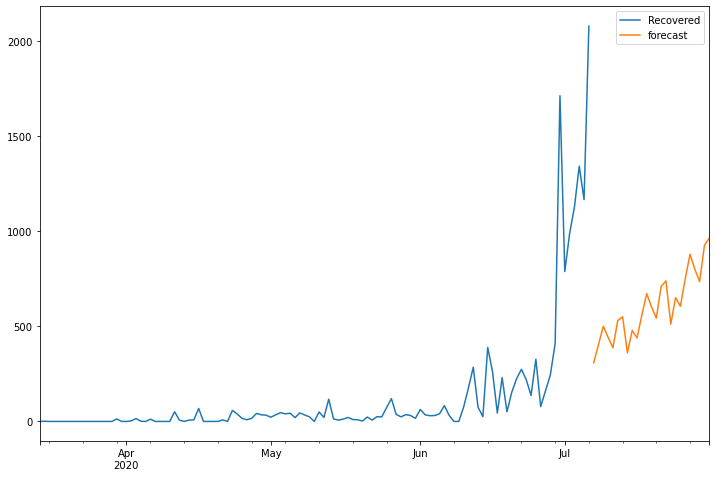

In [294]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [295]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Recovered': 2020-07-07    307.993871
 2020-07-08    404.614599
 2020-07-09    500.719043
 2020-07-10    441.376496
 2020-07-11    387.055994
 2020-07-12    530.229538
 2020-07-13    550.185323
 2020-07-14    360.772754
 2020-07-15    478.520841
 2020-07-16    439.020872
 2020-07-17    559.439464
 2020-07-18    671.922937
 2020-07-19    602.537686
 2020-07-20    542.731480
 2020-07-21    709.988083
 2020-07-22    738.384092
 2020-07-23    511.524032
 2020-07-24    650.572158
 2020-07-25    604.948438
 2020-07-26    749.560303
 2020-07-27    878.818214
 2020-07-28    799.785669
 2020-07-29    734.889170
 2020-07-30    926.624242
 2020-07-31    963.855884
 Freq: D, dtype: float64}

In [296]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Recovered
2020-07-07,307.993871
2020-07-08,404.614599
2020-07-09,500.719043
2020-07-10,441.376496
2020-07-11,387.055994
2020-07-12,530.229538
2020-07-13,550.185323
2020-07-14,360.772754
2020-07-15,478.520841
2020-07-16,439.020872


In [297]:
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')
# future_predicted_df.index.freq = 'D'
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_TG.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_TG.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered
Date                                                              
2020-07-07                 1799.377006                  307.993871
2020-07-08                 1849.404154                  404.614599
2020-07-09                 2023.755527                  500.719043
2020-07-10                 2161.276984                  441.376496
2020-07-11                 2222.075770                  387.055994
2020-07-12                 2283.987344                  530.229538
2020-07-13                 2404.790353                  550.185323
2020-07-14                 2455.207111                  360.772754
2020-07-15                 2624.933851                  478.520841
2020-07-16                 2759.696072                  439.020872
2020-07-17                 2841.586199                  559.439464
2020-07-18                 2921.987450                  671.922937
2020-07-19                 3078.477558                  602.53